<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/statistical-rethinking/lecture-02-statistical-rethinking_chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Rethinking
## Chapter 2. 


GPU check

In [2]:
!nvidia-smi

Tue Sep 24 05:21:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Dependencies



In [3]:
# install pyro
!pip3 install pyro-ppl

     |████████████████████████████████| 276kB 2.7MB/s 
     |████████████████████████████████| 748.9MB 27kB/s 
     |████████████████████████████████| 61kB 24.2MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.1-cp36-none-any.whl size=371731 sha256=69e1bf146a43f938490da6ebd1a56aa5ad232a6ee2c16664c7a11f420a568fee
  Stored in directory: /root/.cache/pip/wheels/fb/47/97/848e699fb40fc9fd17f421c135cf7bc121dcf3f0c8519e89b2
Successfully built pyro-ppl
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [8]:
# usual suspects
import numpy as np
import seaborn as sns
import pymc3 as pm
import torch 
import pyro
import pyro.distributions as dist
import scipy.stats as stats
import matplotlib.pyplot as plt

# see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

print('pymc3:', pm.__version__)

pymc3: 3.7


## Code 2.1

#### PyTorch

In [0]:
ways = torch.tensor([0., 3., 8., 9., 0.])
print('ways.sum()', ways.sum())
ways / ways.sum()

ways.sum() tensor(20.)


tensor([0.0000, 0.1500, 0.4000, 0.4500, 0.0000])

#### numpy / pymc3

In [0]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## Code 2.2

**Numpy**

In [0]:
# draw samples from a binomial distribution

# sample size
N = 6

# observed/ known probability?
p = 0.5

np.random.binomial(N, p)


5

**PyTorch**

In [0]:
dist.Binomial(total_count=9, probs=0.5).log_prob(torch.tensor(6.)).exp()

tensor(0.1641)

#### numpy / pycm3

In [0]:
# binomial discrete random variable
# likelihood???


# observed occurences / drawing water
W = 6

# sample size / trials
N = 9

# probability of drawing W
P=0.5

stats.binom.pmf(W, n=N, p=P)

0.16406250000000006

## Code 2.3

---




#### PyTorch

In [0]:
# define grid
n = 20

p_grid = torch.linspace(start=0, end=1, steps=n)
# p_grid

In [0]:
# define prior
prior = torch.tensor(1.).repeat(n)
# prior

In [0]:
# compute likelihood at each value in grid
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6.)).exp()
# likelihood

In [0]:
# compute product of likelihood and prior
unstd_posterior = likelihood * prior
# unstd_posterior

In [0]:
# standarize the posterior 
posterior = unstd_posterior / unstd_posterior.sum()
# posterior

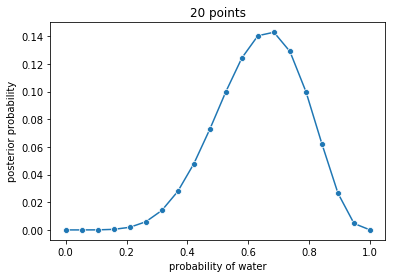

In [0]:
ax = sns.lineplot(p_grid, posterior, marker="o")
ax.set(xlabel="probability of water", ylabel="posterior probability",
       title="20 points");

#### numpy / pycm3

In [0]:
def posterior_grid_aprox(grid_points=5, success=6, tosses=9):
  # define grid
  p_grid = np.linspace(0, 1, grid_points)

  # define prior
  prior = np.repeat(5, grid_points)

  # compute likelihood at each point in the grid
  likelihood = stats.binom.pmf(success, tosses, p_grid)

  # compute product of likelihood * prior
  unstd_posterior = likelihood * prior

  posterior = unstd_posterior / unstd_posterior.sum()
  return p_grid, posterior


In [0]:
points = 23
w, n = 6, 9
p_grid, posterior = posterior_grid_aprox(points, w, n)

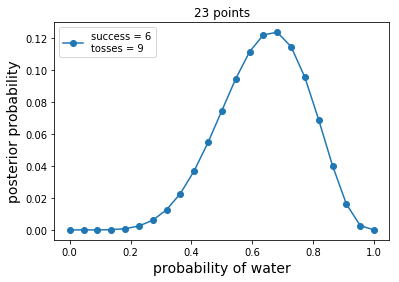

In [0]:
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

### Code 2.6

Computing the posterior using the quadratic approximation.

**PyCM3**

In [5]:
data = np.repeat((0, 1), (3, 6))
data

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [10]:
with pm.Model() as normal_approximation:
  p = pm.Uniform('p', 0, 1)
  w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
  mean_q = pm.find_MAP()
  std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
  
print('mean_q:', mean_q['p'])
print('std_q:', std_q)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 895.81it/s]


mean_q: 0.6666666671652423
std_q: [0.15713484]


In [11]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1 - prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z
pi

array([0.41553484, 0.91779849])